In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Physical constants (cgs)
G = 6.67430e-8
c = 2.99792458e10

M_sun = 1.98847e33
R_sun = 6.957e10

In [121]:
# Polytropic EOS parameters (typical NS toy model)
gamma = 2.0          # stiff EOS
K = 1e5              # cgs units (we will vary rho_c instead)

def P_of_rho(rho):
    return K * rho**gamma

def rho_of_P(P):
    return (P / K)**(1/gamma)

In [122]:
def tov_rhs(r, y):
    m, P = y

    if P <= 0:
        return [0.0, 0.0]

    rho = rho_of_P(P)

    dm_dr = 4 * np.pi * r**2 * rho

    num = G * (rho + P/c**2) * (m + 4*np.pi*r**3 * P/c**2)
    den = r * (r - 2*G*m/c**2)
    dP_dr = -num / max(den, 1e-30)

    return [dm_dr, dP_dr]

In [123]:
def surface_event(r, y):
    return y[1]  # stop when P → 0

surface_event.terminal = True
surface_event.direction = -1


def integrate_tov(rho_c, r_max=2e6):
    P_c = P_of_rho(rho_c)

    r0 = 1.0  # cm
    m0 = (4/3)*np.pi*r0**3 * rho_c
    y0 = [m0, P_c]

    sol = solve_ivp(
        tov_rhs,
        (r0, r_max),
        y0,
        events=surface_event,
        rtol=1e-6,
        atol=1e-8,
        max_step=1e4
    )

    if sol.t_events[0].size > 0:
        R = sol.t_events[0][0]
        M = sol.y_events[0][0][0]
    else:
        R = sol.t[-1]
        M = sol.y[0, -1]

    return M, R

In [124]:
rho_c_test = 1e15  # g/cm^3
M_cgs, R_cgs = integrate_tov(rho_c_test)

print("M/Msun =", M_cgs / M_sun)
print("R (km) =", R_cgs / 1e5)

M/Msun = 1.2206432726948118
R (km) = 12.475786851503349


Max GR mass = 1.65360215906875 Msun at rho_c = 3911178998833161.0
R at max mass = 9.132169955405102 km


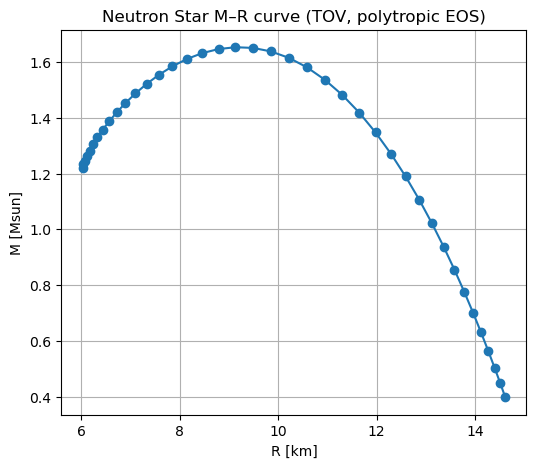

In [125]:
rho_grid = np.logspace(14.3, 16.7, 40)

M_list = []
R_list = []

for rc in rho_grid:
    M, R = integrate_tov(rc)
    M_list.append(M / M_sun)
    R_list.append(R / 1e5)  # km

M_list = np.array(M_list)
R_list = np.array(R_list)

imax = np.argmax(M_list)
print("Max GR mass =", M_list[imax], "Msun at rho_c =", rho_grid[imax])
print("R at max mass =", R_list[imax], "km")

plt.figure(figsize=(6,5))
plt.plot(R_list, M_list, marker="o")
plt.xlabel("R [km]")
plt.ylabel("M [Msun]")
plt.title("Neutron Star M–R curve (TOV, polytropic EOS)")
plt.grid(True)
plt.savefig("../figures/ns_MR_TOV_polytrope.png", dpi=200, bbox_inches="tight")
plt.show()


In [126]:
# --- EOS helper for TOV ---
def rho0_of_P(P):
    # rest-mass density (g/cm^3)
    return (P / K)**(1/gamma)

def eps_of_P(P):
    # energy density epsilon (erg/cm^3) = rho_energy * c^2
    # epsilon = rho0*c^2 + internal_energy_density
    rho0 = rho0_of_P(P)
    return rho0 * c**2 + P/(gamma - 1.0)

def rho_energy_of_P(P):
    # energy density converted to "mass density" units (g/cm^3)
    return eps_of_P(P) / c**2


In [127]:
def tov_rhs_3(r, y):
    m, P, mP = y

    if P <= 0:
        return [0.0, 0.0, 0.0]

    rho0 = rho0_of_P(P)                 # rest-mass density
    rhoE = rho_energy_of_P(P)           # energy density / c^2

    dm_dr = 4 * np.pi * r**2 * rhoE

    num = G * (rhoE + P/c**2) * (m + 4*np.pi*r**3 * P/c**2)
    den = r * (r - 2*G*m/c**2)
    dP_dr = -num / max(den, 1e-30)

    # baryonic mass
    fac = 1.0 / np.sqrt(max(1.0 - 2*G*m/(r*c**2), 1e-30))
    dmP_dr = 4 * np.pi * r**2 * rho0 * fac

    return [dm_dr, dP_dr, dmP_dr]


In [128]:
def surface_event_3(r, y):
    return y[1]  # P

surface_event_3.terminal = True
surface_event_3.direction = -1


def integrate_tov_3(rho_c, r_max=2e6):
    P_c = P_of_rho(rho_c)

    r0 = 1.0  # cm
    rho0_c = rho_c  # for our simple polytrope, central rest density ~ rho_c
    m0 = (4/3)*np.pi*r0**3 * rho_energy_of_P(P_c)
    mP0 = (4/3)*np.pi*r0**3 * rho0_c
    y0 = [m0, P_c, mP0]

    sol = solve_ivp(
        tov_rhs_3,
        (r0, r_max),
        y0,
        events=surface_event_3,
        rtol=1e-6,
        atol=1e-8,
        max_step=1e4
    )

    if sol.t_events[0].size > 0:
        R = sol.t_events[0][0]
        m, P, mP = sol.y_events[0][0]
    else:
        R = sol.t[-1]
        m, P, mP = sol.y[:, -1]

    return m, R, mP


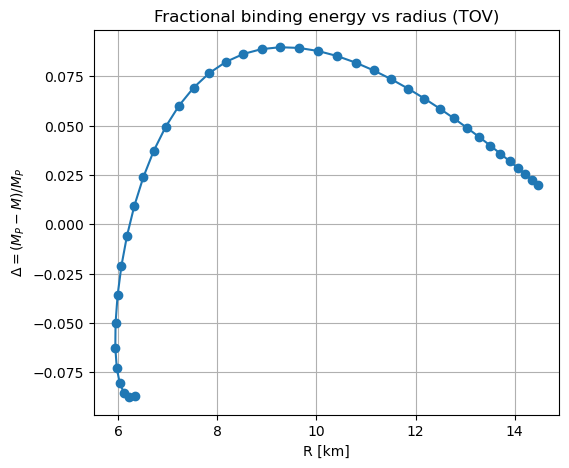

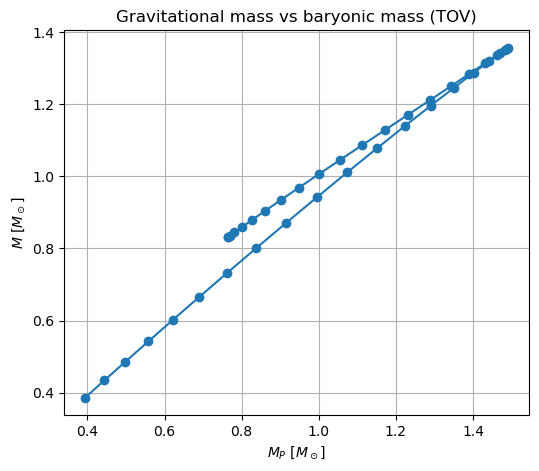

In [129]:
rho_grid = np.logspace(14.3, 16.7, 40)

M_list, R_list, MP_list, Delta_list = [], [], [], []

for rc in rho_grid:
    M, R, MP = integrate_tov_3(rc)
    M_s = M / M_sun
    MP_s = MP / M_sun
    R_km = R / 1e5

    M_list.append(M_s)
    MP_list.append(MP_s)
    R_list.append(R_km)
    Delta_list.append((MP_s - M_s) / MP_s)

M_list = np.array(M_list)
MP_list = np.array(MP_list)
R_list = np.array(R_list)
Delta_list = np.array(Delta_list)

# Plot 1: Delta vs R
plt.figure(figsize=(6,5))
plt.plot(R_list, Delta_list, marker="o")
plt.xlabel("R [km]")
plt.ylabel(r"$\Delta = (M_P - M)/M_P$")
plt.title("Fractional binding energy vs radius (TOV)")
plt.grid(True)
plt.savefig("../figures/ns_binding_delta_vs_R.png", dpi=200, bbox_inches="tight")
plt.show()

# Plot 2: M vs MP (cusps appear)
plt.figure(figsize=(6,5))
plt.plot(MP_list, M_list, marker="o")
plt.xlabel(r"$M_P\ [M_\odot]$")
plt.ylabel(r"$M\ [M_\odot]$")
plt.title("Gravitational mass vs baryonic mass (TOV)")
plt.grid(True)
plt.savefig("../figures/ns_M_vs_MP.png", dpi=200, bbox_inches="tight")
plt.show()


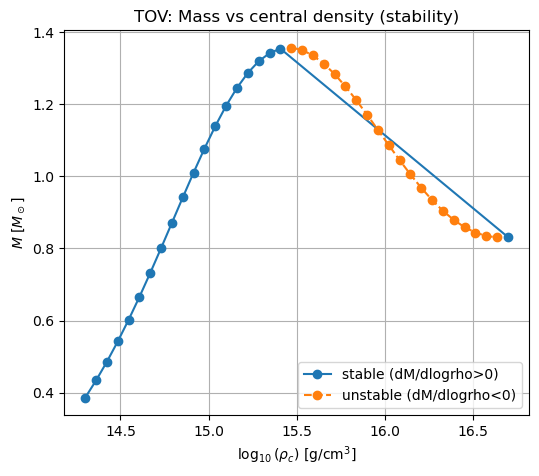

Max GR mass = 1.3569695422814692 Msun at rho_c = 2945986614480109.0 g/cm^3
R at max mass = 9.266607642072607 km
Delta at max mass = 0.08967639618972914


In [130]:
# M vs rho_c and stability
logrho = np.log10(rho_grid)
dM = np.gradient(M_list, logrho)

stable = dM > 0
unstable = ~stable

plt.figure(figsize=(6,5))
plt.plot(logrho[stable], M_list[stable], "o-", label="stable (dM/dlogrho>0)")
plt.plot(logrho[unstable], M_list[unstable], "o--", label="unstable (dM/dlogrho<0)")
plt.xlabel(r"$\log_{10}(\rho_c)\ [\mathrm{g/cm^3}]$")
plt.ylabel(r"$M\ [M_\odot]$")
plt.title("TOV: Mass vs central density (stability)")
plt.grid(True)
plt.legend()
plt.savefig("../figures/ns_M_vs_rhoc_stability.png", dpi=200, bbox_inches="tight")
plt.show()

imax = np.argmax(M_list)
print("Max GR mass =", M_list[imax], "Msun at rho_c =", rho_grid[imax], "g/cm^3")
print("R at max mass =", R_list[imax], "km")
print("Delta at max mass =", Delta_list[imax])


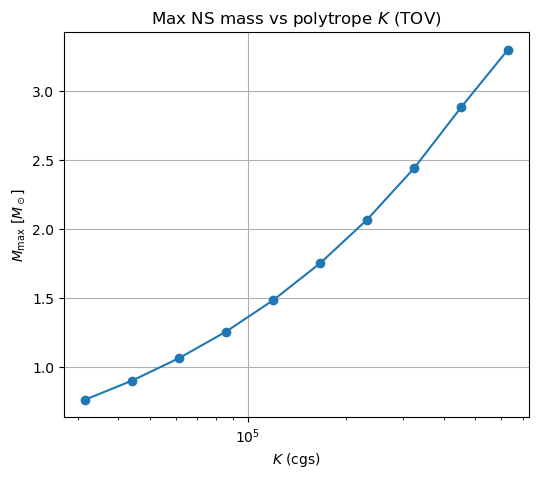

K values with Mmax >= 2.5 Msun: [452434.33466167 630957.34448019]


In [131]:
K_values = np.logspace(4.5, 5.8, 10)  # you can widen if needed
Mmax_list = []
R_at_Mmax = []

for Ktrial in K_values:
    K = Ktrial  # update global K used by EOS

    rho_grid_local = np.logspace(14.3, 16.9, 35)
    M_local = []
    R_local = []

    for rc in rho_grid_local:
        M, R, MP = integrate_tov_3(rc)
        M_local.append(M/M_sun)
        R_local.append(R/1e5)

    M_local = np.array(M_local)
    R_local = np.array(R_local)

    im = np.argmax(M_local)
    Mmax_list.append(M_local[im])
    R_at_Mmax.append(R_local[im])

Mmax_list = np.array(Mmax_list)
R_at_Mmax = np.array(R_at_Mmax)

plt.figure(figsize=(6,5))
plt.plot(K_values, Mmax_list, marker="o")
plt.xscale("log")
plt.xlabel(r"$K$ (cgs)")
plt.ylabel(r"$M_{\max}\ [M_\odot]$")
plt.title(r"Max NS mass vs polytrope $K$ (TOV)")
plt.grid(True)
plt.savefig("../figures/ns_Mmax_vs_K.png", dpi=200, bbox_inches="tight")
plt.show()

# allowed K for 2.5 Msun observation
mask = Mmax_list >= 2.5
print("K values with Mmax >= 2.5 Msun:", K_values[mask])
